In [1]:
import numpy as np
from graphviz import Digraph

In [66]:
class Variable:
    count = 0
    def __init__(self, value, grad = 0, parents=(), op=''):
        self.value = value # keeps track of the function value f(x)
        self.grad = grad # keeps track of the derivative f'(x)
        self.parents = set(parents)
        self.op = op
        self.name = 'x_' + str(Variable.count)
        Variable.count += 1
    
    def __repr__(self):
        return f"Variable(value={self.value}, grad={self.grad}, name=\"{self.name}\", op=\"{self.op}\", n_parents={len(self.parents)})"

    def __add__(self, other):
        other = other if isinstance(other, Variable) else Variable(other)
        return Variable(self.value + other.value, self.grad + other.grad, (self, other), op='+')

    def __radd__(self, other):
        other = other if isinstance(other, Variable) else Variable(other)
        return Variable(self.value + other.value, self.grad + other.grad, (self, other), op='+')

    def __mul__(self, other):
        other = other if isinstance(other, Variable) else Variable(other)
        return Variable(self.value * other.value, self.value * other.grad + other.value * self.grad, (self, other), op='*')

    def _rmul__(self, other):
        other = other if isinstance(other, Variable) else Variable(other)
        return Variable(self.value * other.value, self.value * other.grad + other.value * self.grad, (self, other), op='*')

    def __pow__(self, number):
        assert isinstance(number, (int, float)), "only supporting int/float powers"
        return Variable(np.power(self.value, number), number * np.power(self.value, number - 1) * self.grad, (self,), op=f'^{number}')

    def __neg__(self):
        return Variable(-self.value, -self.grad)

    def __sub__(self, other):
        out = self + (-other)
        out.parents = set((self, other))
        out.op = '-'
        return out

    def __rsub__(self, other):
        out = other + (-self)
        out.parents = set((self, other))
        out.op = '-'
        return out

    def __truediv__(self, other):
        other = other if isinstance(other, Variable) else Variable(other)
        return Variable(self.value / other.value, (self.grad * other.value - self.value * other.grad) / other.value**2, (self, other), op='/')

    def __rtruediv__(self, other):
        other = other if isinstance(other, Variable) else Variable(other)
        return Variable(other.value / self.value, (other.grad * self.value - other.value * self.grad) / self.value**2, (self, other), op='/')

    def sin(self):
        return Variable(np.sin(self.value), self.grad * np.cos(self.value), (self,), op='sin')

    def cos(self):
        return Variable(np.cos(self.value), -np.sin(self.value) * self.grad, (self,), op='cos')

    def tan(self):
        return self.sin() / self.cos()

    def log(self):
        return Variable(np.log(self.value), self.grad * (1.0 / self.value), (self,), op='log')
    
    def exp(self):
        return Variable(np.exp(self.value), self.grad * np.exp(self.value), (self,), op='exp')

    def topsort(self):
        sorted_nodes = []
        visited = set()
        
        def dfs(v):
            if v in visited:
                return
            visited.add(v)
            for nei in v.parents:
                dfs(nei)
            sorted_nodes.append(v)
            
        dfs(self)
        return sorted_nodes

    def build_graph(self):
        edges, nodes = set(), set()

        def dfs(v):
            if v not in nodes:
                nodes.add(v)
                for nei in v.parents:
                    edges.add((nei, v))
                    dfs(nei)
            
        dfs(self)
        return nodes, edges


def draw_dag(root, rankdir='LR'):
    assert rankdir in ['LR', 'TB']
    # Compute the nodes and edges using the `trace` function we just
    # described in the `Variable` class.
    nodes, edges = root.build_graph()

    # A diagraph is the kind of visualization we're after.
    # Format is the output type. You can change this to png, jpeg, etc.
    # Rankdir must be either LR (left-to-right) or TB (top-to-bottom)
    dot = Digraph(format='svg', graph_attr={'rankdir': rankdir})
    
    for n in nodes: # For each node
        # Add a node with the machine name of this object
        # There are many kinds of shapes available; https://graphviz.org/doc/info/shapes.html
        # We will use the 'record' shape containing the primal and tangent value rounded
        # to 3 digits.
        dot.node(name=str(id(n)), label = "{value: %.3f} | {grad: %.3f}" % (n.value, n.grad), shape='record')
        if n.op: # If this is an op (as in the name op is not empty)
            # Add a node and name it the machine name + the op
            dot.node(name=str(id(n)) + n.op, label=n.op)
            # Connect an edge between this newly created op and the parent node
            dot.edge(str(id(n)) + n.op, str(id(n)))
    
    for n1, n2 in edges: # For the nodes in each edge
        # Add an edge
        dot.edge(str(id(n1)), str(id(n2)) + n2.op)
    
    # Return the graph
    return dot

In [67]:
x = Variable(10, 1)

np.log(x**2 - x) * np.sin(x ** (1/2))

Variable(value=-0.09307195519339621, grad=-0.7156966977207482, name="x_7", op="*", n_parents=2)

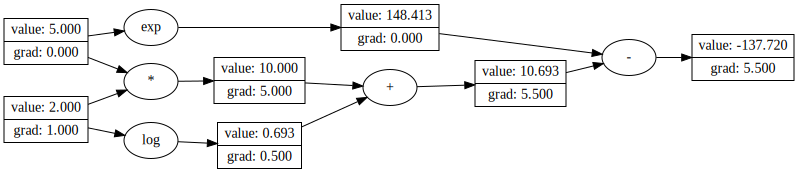

In [68]:
x1 = Variable(2, 1)
x2 = Variable(5, 0)

y = np.log(x1) + x1*x2 - np.exp(x2)
draw_dag(y)